# RSI Mean-Reversion Strategie

Dieses Notebook demonstriert die RSI Mean-Reversion Strategie:
1. Daten laden (BTC/USDT, 1d, letztes Jahr)
2. RSI-Strategie anwenden
3. Backtest ausfuehren
4. Visualisierung: Signale, RSI-Subplot, Equity Curve

In [1]:
from tradestrats.data.fetcher import fetch_ohlcv
from tradestrats.strategies.rsi_mean_reversion import RSIMeanReversion
from tradestrats.backtesting.engine import run
from tradestrats.visualization.charts import plot_signals, plot_equity_curve

import plotly.graph_objects as go
from plotly.subplots import make_subplots

## 1. Daten laden

BTC/USDT Daily-Kerzen fuer das letzte Jahr. Daily eignet sich gut fuer RSI.

In [2]:
from datetime import datetime, timedelta

end = datetime.utcnow()
start = end - timedelta(days=365)

data = fetch_ohlcv("BTC/USDT", timeframe="1d", start=start, end=end)
print(f"Fetched {len(data)} candles")
data.tail()

/tmp/ipykernel_29823/3962132176.py:3: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



Fetched 365 candles


,open,high,low,close,volume
timestamp,,,,,
2026-02-14 00:00:00+00:00,68853.97,70560.01,68730.13,69822.95,18114.78393
2026-02-15 00:00:00+00:00,69822.94,70983.00,68000.00,68832.58,22290.05208
2026-02-16 00:00:00+00:00,68832.59,70126.67,67294.11,68892.43,15515.76534
2026-02-17 00:00:00+00:00,68892.43,69241.50,66621.06,67503.52,16489.06921
2026-02-18 00:00:00+00:00,67503.52,68476.22,66892.03,67479.60,5172.95935


## 2. RSI-Strategie anwenden

Standard-Parameter: RSI(14), Oversold < 30, Overbought > 70.

In [3]:
strategy = RSIMeanReversion(rsi_period=14, oversold=30, overbought=70)
print(strategy)

signals = strategy.generate_signals(data)
signals[["close", "rsi", "signal"]].tail(10)

RSIMeanReversion(period=14, oversold=30, overbought=70)


,close,rsi,signal
timestamp,,,
2026-02-09 00:00:00+00:00,70138.00,33.274468,0
2026-02-10 00:00:00+00:00,68841.29,31.927382,0
2026-02-11 00:00:00+00:00,67082.52,30.144809,0
2026-02-12 00:00:00+00:00,66272.17,29.332209,1
2026-02-13 00:00:00+00:00,68853.96,35.314965,0
2026-02-14 00:00:00+00:00,69822.95,37.455165,0
2026-02-15 00:00:00+00:00,68832.58,36.139061,0
2026-02-16 00:00:00+00:00,68892.43,36.284765,0
2026-02-17 00:00:00+00:00,67503.52,34.327394,0


## 3. Backtest ausfuehren

In [4]:
result = run(strategy, data, init_cash=10_000, fees=0.001)

for key, value in result.summary().items():
    print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

total_return: -0.1017
sharpe_ratio: -0.2961
max_drawdown: -0.2019
total_trades: 2
win_rate: 0.5000


## 4. Visualisierung

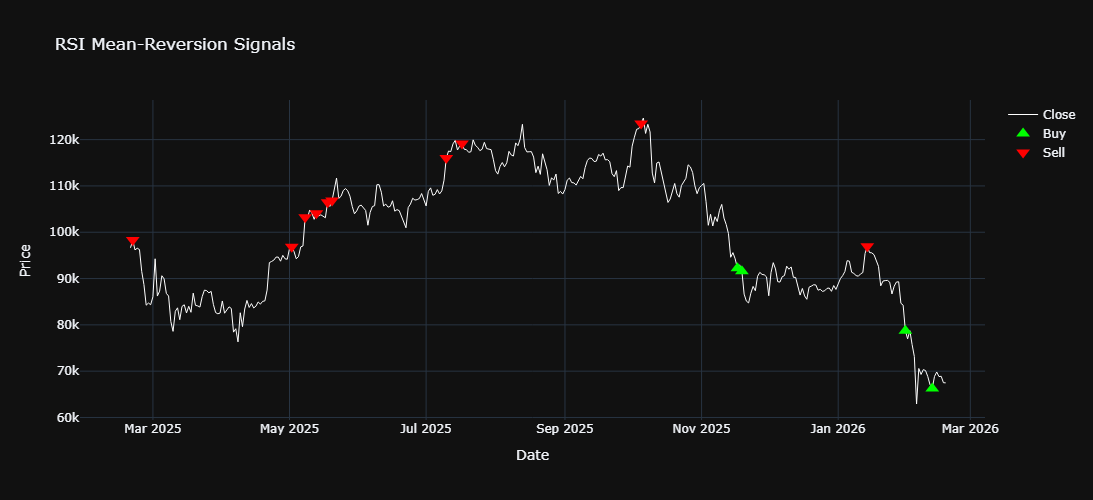

In [5]:
# Buy/Sell-Signale auf dem Preischart
fig = plot_signals(data, signals, title="RSI Mean-Reversion Signals")
fig.show()

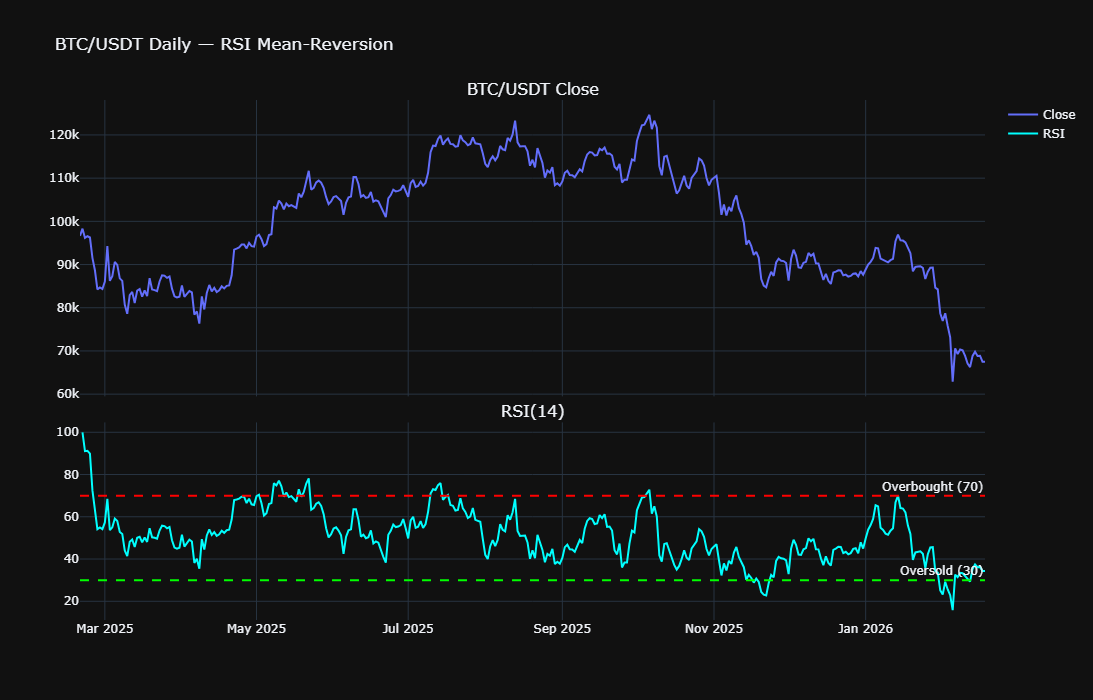

In [6]:
# RSI-Subplot mit Overbought/Oversold-Linien
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.6, 0.4],
    subplot_titles=("BTC/USDT Close", "RSI(14)"),
)

# Price
fig.add_trace(
    go.Scatter(x=signals.index, y=signals["close"], mode="lines", name="Close"),
    row=1, col=1,
)

# RSI
fig.add_trace(
    go.Scatter(x=signals.index, y=signals["rsi"], mode="lines", name="RSI",
               line=dict(color="cyan")),
    row=2, col=1,
)

# Overbought / Oversold reference lines
fig.add_hline(y=70, line_dash="dash", line_color="red",
              annotation_text="Overbought (70)", row=2, col=1)
fig.add_hline(y=30, line_dash="dash", line_color="lime",
              annotation_text="Oversold (30)", row=2, col=1)

fig.update_layout(
    height=700,
    template="plotly_dark",
    title="BTC/USDT Daily — RSI Mean-Reversion",
)
fig.show()

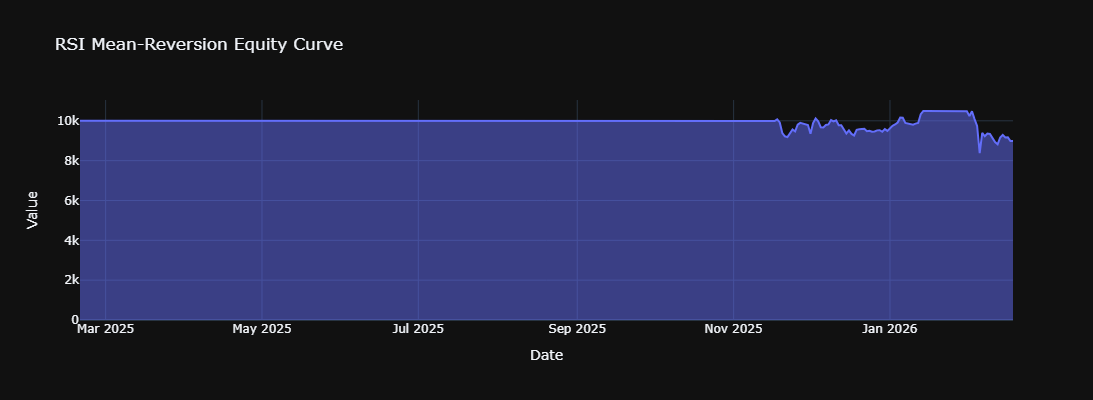

In [7]:
# Equity Curve
fig = plot_equity_curve(result.equity_curve, title="RSI Mean-Reversion Equity Curve")
fig.show()